In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import lambeq as lq
from lambeq.pregroups import remove_cups
from lambeq import AtomicType, IQPAnsatz, BobcatParser
import pennylane as qml
from discopy import grammar, Circuit, Swap, H, Measure

from discopy import grammar
from discopy.grammar import Word
from discopy.rigid import Cap, Cup, Id, Ty
import torch
import random

c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\lambeq\text2diagram\ccg_parser.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Sadrzadeh-Kartsaklis-TransativeWordData Import

In [2]:
# read the text file into a pandas dataframe
#df = pd.read_csv('Sadrzadeh-Kartsaklis-TransativeWordData.txt', sep=' ')
df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')

# assign column names to the dataframe
df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']

# group the data by the three sentence columns and calculate the mean and standard deviation of the score column
grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()

# flatten the multi-level column names of the grouped data
grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]

# rename the mean and std columns to 'score' and 'range' respectively
grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()

unique_word_list = []
for ind, row in grouped_data.iterrows():
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

grouped_data.describe()

,score,range
count,108.000000,108.000000
mean,0.372650,0.923883
std,0.230505,0.538162
min,0.162338,0.000000
25%,0.187923,0.495386
50%,0.269481,0.972611
75%,0.514069,1.348797
max,1.000000,1.929594


In [3]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range
0,agent,sell,property,family,buy,home,0.507305,1.541104
1,agent,sell,property,group,hold,meeting,0.189394,0.481543
2,author,write,book,delegate,buy,land,0.183512,0.625543
3,author,write,book,man,hear,word,0.266234,1.036018
4,author,write,book,writer,read,word,0.514069,1.090140
...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427
104,woman,drink,water,system,use,method,0.175866,0.408248
105,worker,join,party,employee,leave,company,0.227273,0.577350
106,writer,read,word,family,receive,letter,0.339433,1.341963


# Sentance Embeddings

In [18]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

SENT_similarities_subject = []

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	#sent1_embeddings = sent1_embeddings /  sent1_embeddings.max()
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	sent2_embeddings = embedder.encode(sent2)
	#sent2_embeddings = sent2_embeddings /  sent2_embeddings.max()
	SENT_similarities_subject.append(1-cosine(sent1_embeddings, sent2_embeddings))

grouped_data['SENT_sent_sim'] = SENT_similarities_subject
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_12404\4293460152.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim
score,1.000000,0.858698,0.797066
range,0.858698,1.000000,0.598361
SENT_sent_sim,0.797066,0.598361,1.000000


(0.1, 1.1)

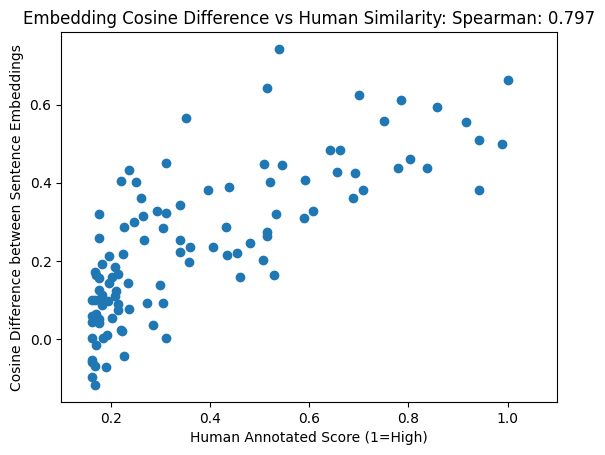

In [19]:
plt.scatter(grouped_data['score'], grouped_data['SENT_sent_sim'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['SENT_sent_sim'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

# Word Embeddings with Sentence Embedder

In [20]:
BERT_similarities_subject,BERT_similarities_verb,BERT_similarities_obj   = [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		rows_embeddings.append(embedder.encode(i))
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0] ,rows_embeddings[3]))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1] , rows_embeddings[4]))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2] , rows_embeddings[5]))

grouped_data['SENT_sub_sim'] = BERT_similarities_subject
grouped_data['SENT_verb_sim'] = BERT_similarities_verb
grouped_data['SENT_obj_sim'] = BERT_similarities_obj
grouped_data['ave'] = (grouped_data['SENT_obj_sim'] +grouped_data['SENT_verb_sim'] +grouped_data['SENT_sub_sim'])/3
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_12404\1715097175.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000


(0.1, 1.1)

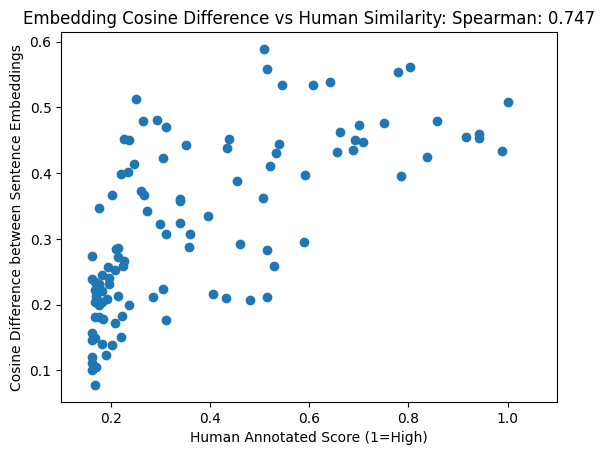

In [21]:
plt.scatter(grouped_data['score'], grouped_data['ave'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['ave'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

Text(0.5, 1.0, 'SquaredError between sum of word encodings and sentence (mean = 0.112)')

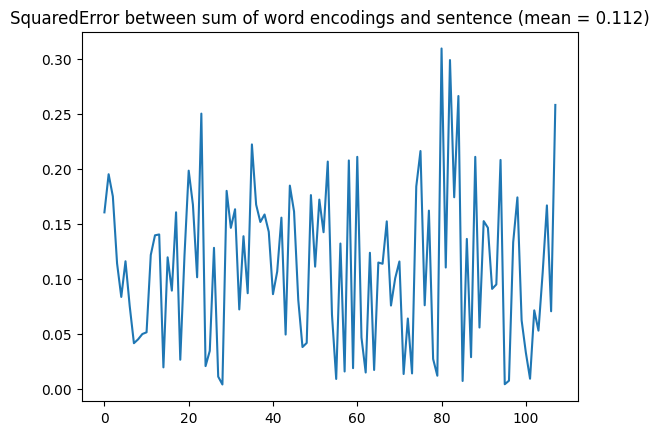

In [22]:
plt.plot(np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2))
plt.title("SquaredError between sum of word encodings and sentence (mean = "+str(np.round(
np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2).mean(), 3))+")")

# Dimension Reduction

In [23]:
def DimReduceByPCA(input_array, new_dims):
	#Pick new_dims Eigenvectors
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def DimReduceBySVD(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

def RotateWordVector(input_word_vector):
	#Define word as a similarity vector compared to all the other words in corpus
	rotated_word_vector = np.zeroes(len(unique_word_list))
	for index, comaprison_word in enumerate(unique_word_list):
		rotated_word_vector[index] = (1-cosine(input_word_vector, embedder.encode(comaprison_word)))
	return rotated_word_vector

In [24]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector

pca_dim = 10
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

Text(0, 0.5, 'Change in similarity from 384 dim to 10')

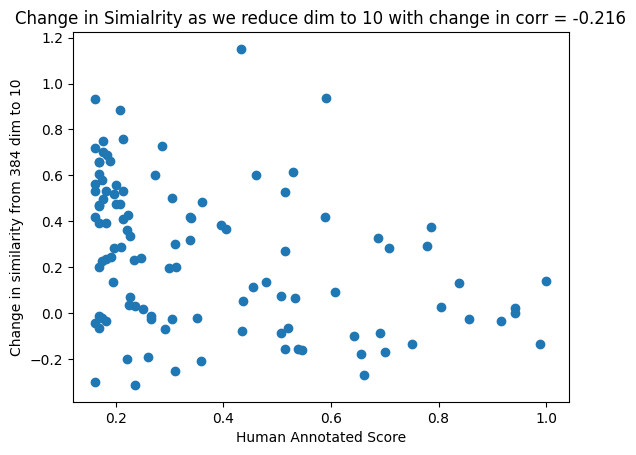

In [25]:
similarities = []
for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = word_vector_dict[row['subject1']][384] + word_vector_dict[row['verb1']][384] + word_vector_dict[row['object1']][384]
	sent2 = word_vector_dict[row['subject2']][384] + word_vector_dict[row['verb2']][384] + word_vector_dict[row['object2']][384]

	sent1_low_dim = word_vector_dict[row['subject1']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb1']]["pca_"+str(pca_dim)] + word_vector_dict[row['object1']]["pca_"+str(pca_dim)]
	sent2__low_dim = word_vector_dict[row['subject2']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb2']]["pca_"+str(pca_dim)] + word_vector_dict[row['object2']]["pca_"+str(pca_dim)]
	similarities.append([1-cosine(sent1, sent2), 1-cosine(sent1_low_dim, sent2__low_dim)])

similarities = np.array(similarities)
plt.scatter(grouped_data['score'], similarities[:,0]-similarities[:,1])
plt.title("Change in Simialrity as we reduce dim to "+str(pca_dim) +" with change in corr = "+str(
	np.round(grouped_data['score'].corr(pd.Series(similarities[:,1]), method='spearman') - grouped_data['score'].corr(pd.Series(similarities[:,0]), method='spearman'), 3)
	))
plt.xlabel("Human Annotated Score")
plt.ylabel("Change in similarity from 384 dim to "+str(pca_dim))

In [26]:
grouped_data['PCA_'+str(pca_dim)] = similarities[:,1]
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_12404\3695999218.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846,0.537317
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353,0.399214
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033,0.721874
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862,0.616374
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512,0.454426
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626,0.527056
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000,0.750198
PCA_10,0.537317,0.399214,0.721874,0.616374,0.454426,0.527056,0.750198,1.000000


In [27]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
0,agent,sell,property,family,buy,home,0.507305,1.541104,0.201549,0.111137,0.687575,0.287326,0.362013,0.394433
1,agent,sell,property,group,hold,meeting,0.189394,0.481543,-0.071638,0.127501,0.288967,-0.046184,0.123428,-0.419797
2,author,write,book,delegate,buy,land,0.183512,0.625543,0.003442,0.157430,0.166433,0.211330,0.178398,-0.365270
3,author,write,book,man,hear,word,0.266234,1.036018,0.252530,0.338995,0.372899,0.388278,0.366724,0.551217
4,author,write,book,writer,read,word,0.514069,1.090140,0.641656,0.755711,0.529858,0.388278,0.557949,0.978626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427,0.192133,0.172855,0.355742,0.207168,0.245255,0.427217
104,woman,drink,water,system,use,method,0.175866,0.408248,0.125207,0.107123,0.355742,0.230542,0.231135,-0.363076
105,worker,join,party,employee,leave,company,0.227273,0.577350,0.285479,0.751912,0.395919,0.208960,0.452264,0.521499
106,writer,read,word,family,receive,letter,0.339433,1.341963,0.253634,0.239393,0.252427,0.481148,0.324322,0.074801


# Quantum Encoding

- Choose an Anzatz with invarient Inner Product

- Export circuit from lambeq/discopy to pennylane - possibly not

- tensor network module

- 12 qubits, 

- discopro - removing cups (kinianlo/discopro)

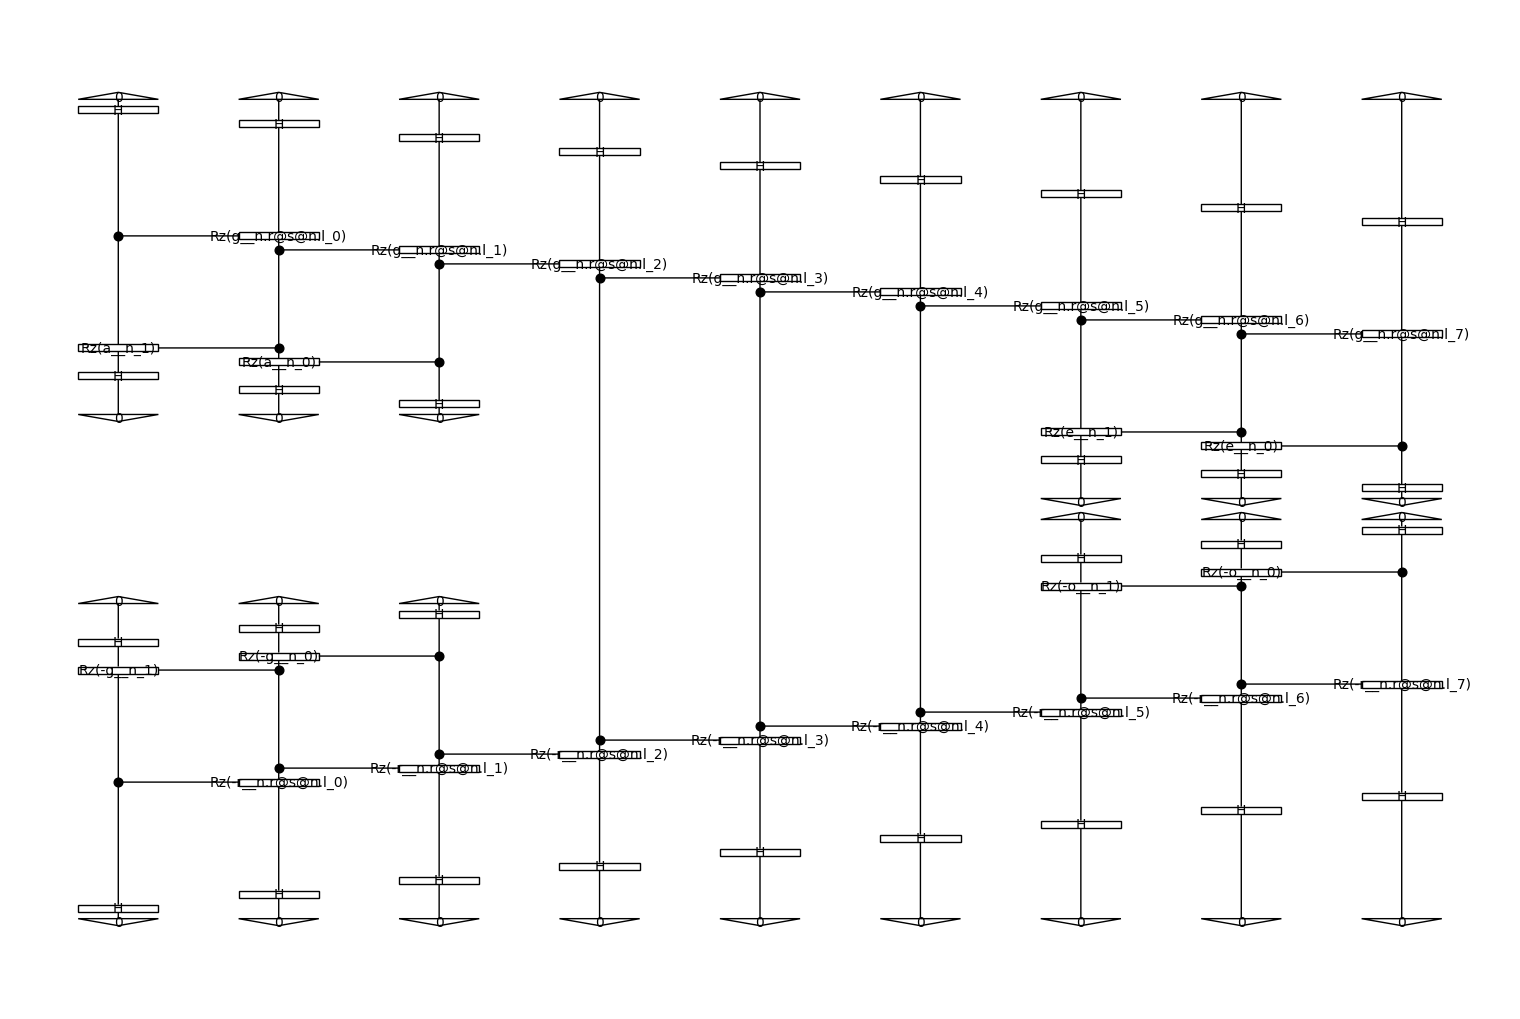

In [4]:
def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')

    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]

    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

    diagram = Id().tensor(*words) >> cups
    return diagram

def make_diagrams(row1, row2=None, drawing=False):
    if not row2:
        row2=row1
    sentence1 = grouped_data['subject'+str(1)][row1] + " " + grouped_data['verb'+str(1)][row1]  + " " + grouped_data['object'+str(1)][row1] 
    sentence2 = grouped_data['subject'+str(2)][row2] + " " + grouped_data['verb'+str(2)][row2]  + " " + grouped_data['object'+str(2)][row2] 
    
    diagram1 = diagram_to_sentence(sentence1)
    diagram1 = remove_cups(diagram1)
    diagram2 = diagram_to_sentence(sentence2)
    diagram2 = remove_cups(diagram2)
    
    if drawing:
        diagram1.draw(figsize=(14,3), fontsize=12)
    return diagram1, diagram2

def make_circuit_from_diagrams(diagram1, diagram2, vector, drawing=False, qubits_noun=3, qubits_subject=3, upload_count=1):
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE

    # Convert string diagram to quantum circuit
    ansatz = IQPAnsatz({N: qubits_noun, S: qubits_subject}, n_layers=upload_count)

    discopy_circuit1 = ansatz(diagram1)
    discopy_circuit2 = ansatz(diagram2)
    discopy_circuit2 = discopy_circuit2.dagger()

    discopy_circuit = discopy_circuit1 >> discopy_circuit2

    #Remove if neccessary...Encode vector into rotation gates
    #num_params = len(vector)
    #for i in range(num_params):
    #    qml.CNOT(wires=[i, i+1])
    #    qml.RX(vector[i][0], wires=i)

    if drawing:
        discopy_circuit.draw(figsize=(15, 10))

    pennylane_circuit = discopy_circuit.to_pennylane()

    return pennylane_circuit, discopy_circuit

def make_circuit_from_data(row_number):
    diagram1, diagram2 = make_diagrams(row_number)
    vector = [(0.1, 0.2, 0.3), (0.4, 0.5, 0.6), (0.7, 0.8, 0.9), (1.0, 1.1, 1.2)]  # Example vector
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, vector, False)
    return qml_circuit, discopy_circuit
    

make_circuit_from_data(1)[1].draw(figsize=(15, 10))

# model

In [5]:
BATCH_SIZE = 10
EPOCHS = 15
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
labels = grouped_data['score']
sentences1 = (grouped_data['subject'+str(1)] + " " + grouped_data['verb'+str(1)]  + " " + grouped_data['object'+str(1)]).tolist()
sentences2 = (grouped_data['subject'+str(1)] + " " + grouped_data['verb'+str(1)]  + " " + grouped_data['object'+str(1)]).tolist()

diagrams = [make_circuit_from_data(i)[1] for i in range(len(grouped_data))]

#train_labels = labels train_data = diagrams dev_labels = labels dev_data = diagrams test_labels = labels test_data = diagrams

In [7]:
from lambeq import PennyLaneModel

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(diagrams,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

AttributeError: 'PennyLaneCircuit' object has no attribute 'initialise_concrete_params'

# Handmade Pennylane

In [ ]:
import matplotlib.pyplot as plt

import pennylane as qml

dev = qml.device("default.qubit", wires=12)

@qml.qnode(device=dev)
def circuit(noun_rotations, subject_rotations, verb_rotations):
    for i in range(0,12):
        qml.Hadamard(wires=i) 
    for i in range(0,4):
        qml.CNOT(wires=[i, i+1])
        qml.RX(noun_rotations[i], wires=i)
    for i in range(4,8):
        qml.CNOT(wires=[i, i+1])
        qml.RX(verb_rotations[i], wires=i)
    for i in range(8,12):
        qml.CNOT(wires=[i, i+1])
        qml.RX(subject_rotations[i], wires=i)
        
        
    qml.PauliX(wires=0),
    qml.PauliY(wires=1),
    qml.CNOT(wires=[0, 1]),
    return qml.expval(qml.PauliZ(wires=0))


g = circuit()

AttributeError: 'tensor' object has no attribute 'draw'